### Imports

In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import re
import datetime
import spotipy
from spotipy.oauth2 import SpotifyOAuth

# Caminho da pasta "Twitch"
base_dir = Path(os.getcwd()).resolve().parent  # Ajuste se necessário

# Adicionar as pasta ao sys.path
data_dir = base_dir / 'data'
src_data_dir = base_dir / 'src' / 'data'
model_data_dir = base_dir / 'src' / 'model'
sys.path.append(str(data_dir))
sys.path.append(str(src_data_dir))
sys.path.append(str(model_data_dir))

try:
    # src/data
    import API_Spotify as api
    import get_data
    import parquet_converter

    # src/model
    import unsupervised as get_clusters
except ImportError as e:
    print(f"Erro: Não foi possível importar o módulo {e.name}. Verifique se o caminho está correto.")

c:\Users\35196\Desktop\Bases de dados distribuídas avançadas\BDDA\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


```powershell
cd .. /
pip install -r requirements.txt

## Get Data

In [2]:
# Diretório onde vão ficar os datasets
data_directory = data_dir / "raw"

def check_directory(data_directory):
    if os.path.exists(data_directory) and os.path.isdir(data_directory):
        if not os.listdir(data_directory):  # Verifica se a lista de ficheiros/diretórios está vazia
            print("A pasta está vazia.")
            return True
        else:
            print("A pasta não está vazia.")
            return False
    else:
        print("A pasta não existe ou não é um diretório.")
        return True

In [3]:
if check_directory(data_directory):
    # Lista de links dos datasets no Kaggle
    links = [
        "hedizekri/top-charts-artists-country",  # Países dos artistas
        "jackharding/spotify-artist-metadata-top-10k",  # Idade, género dos artistas
        "rodolfofigueroa/spotify-12m-songs",  # Spotify 12M Songs
        "estienneggx/spotify-unpopular-songs",  # Unpopular Songs
    ]

    # Executa o processo de download e conversão
    get_data.kaggleDownload(data_directory, links)

A pasta não está vazia.


## Artists

In [4]:
Artist_country =  pd.read_csv(data_directory / "Top_Charts_Artists_Country.csv")
Artist_metaData = pd.read_csv(data_directory / "top10k-spotify-artist-metadata.csv")
Artist_country

,Artist,Country
0,Miley Cyrus,United States
1,FIFTY FIFTY,United Kingdom
2,ROSALÍA,Spain
3,PinkPantheress,United Kingdom
4,Metro Boomin,United States
...,...,...
960,Meck,United Kingdom
961,Matt Simons,United States
962,Hoodie Forester,Netherlands
963,NSB,United States


In [5]:
Artist_metaData

,Unnamed: 0,index,artist,gender,age,type,country,city_1,district_1,city_2,district_2,city_3,district_3
0,0,0,Drake,male,33,person,CA,NaN,NaN,Toronto,NaN,NaN,NaN
1,1,1,Post Malone,male,25,person,US,NaN,NaN,Syracuse,NaN,NaN,NaN
2,2,2,Ed Sheeran,male,29,person,GB,NaN,NaN,Halifax,NaN,NaN,NaN
3,3,3,J Balvin,male,35,person,CO,NaN,NaN,Medellín,NaN,NaN,NaN
4,4,4,Bad Bunny,male,26,person,PR,NaN,NaN,San Juan,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,4991,si_el_bien,NaN,0,NaN,NaN,Chicago,NaN,NaN,NaN,NaN,NaN
9996,9996,4992,Antonello Venditti,male,71,person,IT,NaN,NaN,Rome,NaN,NaN,NaN
9997,9997,4993,Lea Salonga,female,49,person,PH,NaN,NaN,NaN,NaN,NaN,NaN
9998,9998,4994,Vertical Horizon,mixed,29,group,NaN,Boston,NaN,NaN,NaN,NaN,NaN


### Limpeza

In [6]:
def clean_text(text):
    if pd.isnull(text):  # Verifica se é nulo
        return text
    # Remove pontuação usando regex
    text = re.sub(r'[^\w\s]', '', text)
    # Converte para minúsculas
    text = text.title()
    # Remove espaços extras
    text = ' '.join(text.split())
    return text

# Colocar nomes uniformizados
Artist_metaData['artist_cleaned'] = Artist_metaData['artist'].apply(clean_text)
Artist_country['artist_cleaned'] = Artist_country['Artist'].apply(clean_text)

In [7]:
# Artistas que não estão presentes na DB secundária (vão ser apagados)
Artist_country[~Artist_country["artist_cleaned"].isin(Artist_metaData["artist_cleaned"])]

,Artist,Country,artist_cleaned
1,FIFTY FIFTY,United Kingdom,Fifty Fifty
3,PinkPantheress,United Kingdom,Pinkpantheress
5,David Kushner,United States,David Kushner
7,Rema,Nigeria,Rema
9,d4vd,United States,D4Vd
...,...,...,...
958,Big Brovaz,United Kingdom,Big Brovaz
960,Meck,United Kingdom,Meck
962,Hoodie Forester,Netherlands,Hoodie Forester
963,NSB,United States,Nsb


In [8]:
# Juntar as tabelas
if 'Artist_metaData' in locals() and 'Artist_country' in locals():
    # Faz o merge entre as duas tabelas com base na coluna 'artist_cleaned'
    merged_table = pd.merge(
        Artist_metaData,
        Artist_country,
        on='artist_cleaned',  # Coluna de ligação
        how='inner'           # Tipo de junção ('inner', 'left', 'right', 'outer')
    )
    del Artist_metaData, Artist_country

# Seleciona apenas as colunas que nos interessam
Artist_details = merged_table[['artist_cleaned', 'gender', 'age', 'Country']]
Artist_details = Artist_details.rename(columns={'artist_cleaned': 'artist_name', 'Country': 'country_born'})

# Queremos artistas singulares, não grupos
Artist_details = Artist_details[Artist_details['gender'] != 'mixed']

# A base de dados com a idade dos artistas foi publicada em 2021
## https://www.kaggle.com/datasets/jackharding/spotify-artist-metadata-top-10k/data
if 0 in Artist_details["age"].unique():
    Artist_details["age"] = Artist_details["age"] + datetime.datetime.now().year - 2021
Artist_details

,artist_name,gender,age,country_born
0,Drake,male,37,Canada
1,Post Malone,male,29,United States
2,Ed Sheeran,male,33,United Kingdom
3,J Balvin,male,39,Colombia
4,Bad Bunny,male,30,Puerto Rico
...,...,...,...,...
651,Mo,NaN,4,United Kingdom
660,Sisqo,male,45,United States
664,Waka Flocka Flame,male,38,United States
665,Lou Bega,male,49,Germany


In [9]:
Artist_details[Artist_details.isnull().any(axis=1)]

,artist_name,gender,age,country_born
53,Annemarie,NaN,4,France
314,Bizarrap,NaN,26,Argentina
357,Big Shaq,NaN,32,United Kingdom
388,Giveon,NaN,4,United States
399,Nsg,NaN,4,Indonesia
424,Mo,NaN,4,United Kingdom
508,Chip,NaN,4,United Kingdom
587,Lyodra,NaN,4,Indonesia
602,Diskoria,NaN,4,Indonesia
651,Mo,NaN,4,United Kingdom


In [10]:
# Definir manualmente os valores da coluna 'gender' para alguns artistas
Artist_details.loc[Artist_details['artist_name'] == 'Annemarie', 'gender'] = 'female'
Artist_details.loc[Artist_details['artist_name'] == 'Bizarrap', 'gender'] = 'Male'
Artist_details.loc[Artist_details['artist_name'] == 'Big Shaq', 'gender'] = 'Male'
Artist_details.loc[Artist_details['artist_name'] == 'Giveon', 'gender'] = 'Male'
Artist_details.loc[Artist_details['artist_name'] == 'Chip', 'gender'] = 'Male'
Artist_details.loc[Artist_details['artist_name'] == 'Lyodra', 'gender'] = 'Female'

# Apagar colunas com valores nulos
Artist_details = Artist_details.dropna(axis=0)

In [11]:
# Definir manualmente os valores da coluna 'age' para alguns artistas
Artist_details.loc[Artist_details['artist_name'] == 'Annemarie', 'age'] = 33 + (2025 - datetime.datetime.now().year)
Artist_details.loc[Artist_details['artist_name'] == 'Bizarrap', 'age'] = 26 + (2025 - datetime.datetime.now().year)
Artist_details.loc[Artist_details['artist_name'] == 'Big Shaq', 'age'] = 33 + (2025 - datetime.datetime.now().year)
Artist_details.loc[Artist_details['artist_name'] == 'Giveon', 'age'] = 29 + (2025 - datetime.datetime.now().year)
Artist_details.loc[Artist_details['artist_name'] == 'Chip', 'age'] = 34 + (2025 - datetime.datetime.now().year)
Artist_details.loc[Artist_details['artist_name'] == 'Lyodra', 'age'] = 21 + (2025 - datetime.datetime.now().year)
Artist_details.loc[Artist_details['artist_name'] == 'Joel Adams', 'age'] = 28 + (2025 - datetime.datetime.now().year)

In [12]:
incorretAge = Artist_details[Artist_details["age"] == datetime.datetime.now().year - 2021][["artist_name", "age"]]
incorretAge

,artist_name,age
50,Manuel Turizo,4
66,Offset,4
85,Paulo Londra,4
93,Tones And I,4
109,Rauw Alejandro,4
124,Lil Pump,4
157,Meduza,4
174,Nio Garcia,4
183,Dynoro,4
188,Saint Jhn,4


In [13]:
# Atualizar as idades na tabela
incorretAge = api.update_artist_ages(incorretAge)

# Atualizar a coluna 'age' na tabela principal
Artist_details = Artist_details.merge(
    incorretAge,  # Tabela secundária
    on='artist_name',  # Coluna de ligação
    how='left',  # Faz uma junção à esquerda
    suffixes=('', '_secondary')  # Adiciona sufixos para diferenciar colunas
)

# Preencher os valores de 'age' com os dados da tabela secundária, se disponíveis
Artist_details['age'] = Artist_details['age_secondary'].combine_first(Artist_details['age'])

# Remover a coluna auxiliar
Artist_details = Artist_details.drop(columns=['age_secondary'])

Artist_details.dropna(inplace=True)

Artist_details

,artist_name,gender,age,country_born
0,Drake,male,37.0,Canada
1,Post Malone,male,29.0,United States
2,Ed Sheeran,male,33.0,United Kingdom
3,J Balvin,male,39.0,Colombia
4,Bad Bunny,male,30.0,Puerto Rico
...,...,...,...,...
487,Miguel,male,54.0,United States
488,Sisqo,male,45.0,United States
489,Waka Flocka Flame,male,38.0,United States
490,Lou Bega,male,49.0,Germany


In [14]:
Artist_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   artist_name   492 non-null    object 
 1   gender        492 non-null    object 
 2   age           492 non-null    float64
 3   country_born  492 non-null    object 
dtypes: float64(1), object(3)
memory usage: 15.5+ KB


In [15]:
Artist_details.describe()

,age
count,492.000000
mean,36.215447
std,11.861142
min,4.000000
25%,30.000000
50%,36.000000
75%,43.000000
max,96.000000


In [16]:
nome_correcoes = {
    "J Cole": "J. Cole",
    "Aap Rocky": "A$AP Rocky",
    "Gigi Dagostino": "Gigi D'Agostino",
    "Machine Gun Kelly": "mgk",
    "Tyler The Creator": "Tyler, The Creator",
    "Dram": "DRAMA",
    "Mr Probz": "Mr. Probz",
    "Russ": "Russ Millions",
    "Neyo": "Ne-Yo",
    "Marc E Bassy": "Marc E. Bassy",
    "Rob Tone": "Rob $tone",
    "Ruth B": "Ruth B.",
    "Mk": "Mk.gee",
    "Ot Genasis": "O.T. Genasis",
    "The Notorious Big": "The Notorious B.I.G.",
    "Eo": "ÉoDan",
    "Dr Dre": "Dr. Dre",
    "Mia": "M.I.A.",
    "Mary J Blige": "Mary J. Blige",
    "Jojo": "Jojo's ASMR",
    "pnk": "pnkcité",
    "Geazy": "G-Eazy",
    "Marina": "MARINA",
    "Thedream":"The-Dream",
    "Ti":"T.I.",
    "Aap Ferg":"A$AP Ferg",
    "Annemarie":"Anne-Marie",
    "Blackbear": "blackbear",
    "Iann Dior": "iann dior",
    "Gnash":"gnash",
    "Ar Rahman":"A.R.Rahman",
    "E40":"E-40",
    "Meduza":"MEDUZA",
    "William":"will.i.am",
    "Dj Fresh":"DJ Fresh",
    "Kyle":"KYLE",
    "Grabrielle":"GRABRIELLE"
}

# Atualiza os nomes no DataFrame
Artist_details["artist_name"] = Artist_details["artist_name"].replace(nome_correcoes)

### Api

In [17]:
# Demora, aproximadamente 0.2674 segundos por artista
# Cuidado, é necessário apagar o ficheiro ".cache" deste diretório

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id="ca14c7679c394052af165d2168f3361f",
    client_secret="8b250ef320964c2a9197f5453f3c449d",
    redirect_uri="https://localhost:1234/callback",
    scope="user-library-read",  # Definindo a scope necessária
    requests_timeout=15))

# Problemas:
## PlayBoi Carti
api.get_artist_details(Artist_details, 'artist_name', sp)
Artist_details[Artist_details.isnull().any(axis=1)]

,artist_name,gender,age,country_born,artist_id,followers,popularity,genres,image_url
61,Anitta,female,31.0,Brazil,None,NaN,NaN,None,None
71,Mø,female,35.0,Denmark,None,NaN,NaN,None,None
166,Yg,male,34.0,United States,7iqXu8imQ1rePIk5Nx1ctV,5.0,0.0,,None
172,Playboi Carti,male,27.0,United States,None,NaN,NaN,None,None
175,Pnk,female,44.0,United States,None,NaN,NaN,None,None
196,Miguel,male,54.0,United States,None,NaN,NaN,None,None
311,Sebastian Ingrosso,male,41.0,Sweden,None,NaN,NaN,None,None
320,Zhu,female,4.0,China,2QHqarwkjOlx0HtV7KyEx9,9.0,0.0,,None
321,Nelly,male,49.0,United States,None,NaN,NaN,None,None
362,Tpain,male,38.0,United States,5Daf0heTiEznki7hU5GerJ,4.0,0.0,,None


In [18]:
# Remover valores nulos e limpar a coluna 'genres'
Artist_details = Artist_details.dropna()  # Remove todas as linhas com valores nulos
Artist_details = Artist_details.dropna(subset=['genres'])  # Remove as linhas onde 'genres' é nulo
Artist_details = Artist_details[Artist_details['genres'].str.strip().ne('')]  # Remove linhas onde 'genres' está vazio

# Remover duplicados
Artist_details = Artist_details.drop_duplicates()

# Resetar o índice
Artist_details = Artist_details.reset_index(drop=True)

# Guardar os dados processados em CSV
processed_data = data_dir / 'processed'
if not os.path.exists(processed_data):
    os.makedirs(processed_data)
Artist_details.to_csv(processed_data / 'artist_details.csv', index=False)

# Mostrar o DataFrame processado
Artist_details


,artist_name,gender,age,country_born,artist_id,followers,popularity,genres,image_url
0,Drake,male,37.0,Canada,3TVXtAsR1Inumwj472S9r4,94924678.0,97.0,"canadian hip hop, canadian pop, hip hop, pop r...",https://i.scdn.co/image/ab6761610000e5eb429338...
1,Post Malone,male,29.0,United States,246dkjvS1zLTtiykXe5h60,46205845.0,91.0,"dfw rap, melodic rap, pop, rap",https://i.scdn.co/image/ab6761610000e5ebe17c0a...
2,Ed Sheeran,male,33.0,United Kingdom,6eUKZXaKkcviH0Ku9w2n3V,118303036.0,90.0,"pop, singer-songwriter pop, uk pop",https://i.scdn.co/image/ab6761610000e5eb784daf...
3,J Balvin,male,39.0,Colombia,1vyhD5VmyZ7KMfW5gqLgo5,37654788.0,88.0,"reggaeton, reggaeton colombiano, trap latino, ...",https://i.scdn.co/image/ab6761610000e5ebdea087...
4,Bad Bunny,male,30.0,Puerto Rico,4q3ewBCX7sLwd24euuV69X,88463237.0,96.0,"reggaeton, trap latino, urbano latino",https://i.scdn.co/image/ab6761610000e5eb744a42...
...,...,...,...,...,...,...,...,...,...
455,Lenny Kravitz,male,60.0,United States,5gznATMVO85ZcLTkE9ULU7,3428610.0,74.0,"permanent wave, rock",https://i.scdn.co/image/ab6761610000e5ebe0cf05...
456,Daniel Bedingfield,male,44.0,United Kingdom,11hIqBsGRPztdjBHCSLClX,225365.0,55.0,"europop, talent show",https://i.scdn.co/image/411b4430f842fca92fedf7...
457,Sisqo,male,45.0,United States,6x9QLdzo6eBZxJ1bHsDkjg,1100081.0,60.0,"contemporary r&b, hip pop, r&b, urban contempo...",https://i.scdn.co/image/65c4f2d897d65c2236ddc7...
458,Waka Flocka Flame,male,38.0,United States,6f4XkbvYlXMH0QgVRzW0sM,2744741.0,68.0,"atl hip hop, dirty south rap, pop rap, rap, so...",https://i.scdn.co/image/ab6761610000e5eb098d90...


## Popular Individual Tracks

In [19]:
Artist_tracks = pd.read_csv(data_directory /"tracks_features.csv")
Artist_tracks

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0EsMifwUmMfJZxzoMPXJKZ,Gospel of Juke,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],2,1,False,0.264,...,0.0672,0.00935,0.002240,0.3370,0.415,159.586,276213,4.0,2014,2014-01-09
1204021,2WSc2TB1CSJgGE0PEzVeiu,Prism Visions,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],3,1,False,0.796,...,0.0883,0.10400,0.644000,0.0749,0.781,121.980,363179,4.0,2014,2014-01-09
1204022,6iProIgUe3ETpO6UT0v5Hg,Tokyo 360,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],4,1,False,0.785,...,0.0564,0.03040,0.918000,0.0664,0.467,121.996,385335,4.0,2014,2014-01-09
1204023,37B4SXC8uoBsUyKCWnhPfX,Yummy!,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],5,1,False,0.665,...,0.0409,0.00007,0.776000,0.1170,0.227,124.986,324455,4.0,2014,2014-01-09


In [20]:
# Adiciona a coluna 'is_solo' para verificar se a música é a solo ou não
Artist_tracks['is_solo'] = Artist_tracks['artist_ids'].apply(lambda x: 1 if x.count(',') == 0 else 0)

# Transformar a coluna _explicit_
Artist_tracks['explicit'] = Artist_tracks['explicit'].astype(int)

# Transformar a coluna em datetime
Artist_tracks['release_date'] = pd.to_datetime(Artist_tracks['release_date'], errors='coerce')
# Criando uma coluna 'year' para o ano
Artist_tracks['year'] = Artist_tracks['release_date'].dt.year
# Criando uma coluna 'month' para o mês
Artist_tracks['month'] = Artist_tracks['release_date'].dt.month

Artist_tracks = Artist_tracks.rename(columns={'id': 'track_id', "artists": "artist_name", "artist_ids": "artist_id"})

# Função para limpar a coluna
def clean_artist_ids(artist_id):
    if artist_id is not None:
        # Remove os caracteres '[' e ']' de ambos os lados e os apóstrofos
        artist_id = artist_id.replace("[", "").replace("]", "").replace("'", "")

        # Se o artista tiver vírgula, ele é removido
        if ',' in artist_id:
            # Divide os IDs em uma lista e retorna o primeiro
            artist_id = artist_id.split(',')[0].strip()  # Pega apenas o primeiro ID

        return artist_id
    return None

# Aplicando a limpeza na coluna
Artist_tracks['artist_id'] = Artist_tracks['artist_id'].apply(clean_artist_ids)
Artist_tracks['artist_name'] = Artist_tracks['artist_name'].apply(clean_artist_ids)
Artist_tracks = Artist_tracks.drop(['track_number', 'disc_number', 'year', 'release_date', 'year', 'month'], axis=1)
Artist_tracks

,track_id,name,album,album_id,artist_name,artist_id,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,is_solo
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,Rage Against The Machine,2d0hyoQ5ynDBnkvAbJKORj,0,0.470,0.978,7,...,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,Rage Against The Machine,2d0hyoQ5ynDBnkvAbJKORj,1,0.599,0.957,11,...,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,Rage Against The Machine,2d0hyoQ5ynDBnkvAbJKORj,0,0.315,0.970,7,...,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,Rage Against The Machine,2d0hyoQ5ynDBnkvAbJKORj,1,0.440,0.967,11,...,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,Rage Against The Machine,2d0hyoQ5ynDBnkvAbJKORj,0,0.426,0.929,2,...,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0EsMifwUmMfJZxzoMPXJKZ,Gospel of Juke,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,FVLCRVM,7AjItKsRnEYRSiBt2OxK1y,0,0.264,0.966,5,...,0,0.0672,0.00935,0.002240,0.3370,0.415,159.586,276213,4.0,1
1204021,2WSc2TB1CSJgGE0PEzVeiu,Prism Visions,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,FVLCRVM,7AjItKsRnEYRSiBt2OxK1y,0,0.796,0.701,11,...,0,0.0883,0.10400,0.644000,0.0749,0.781,121.980,363179,4.0,1
1204022,6iProIgUe3ETpO6UT0v5Hg,Tokyo 360,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,FVLCRVM,7AjItKsRnEYRSiBt2OxK1y,0,0.785,0.796,9,...,0,0.0564,0.03040,0.918000,0.0664,0.467,121.996,385335,4.0,1
1204023,37B4SXC8uoBsUyKCWnhPfX,Yummy!,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,FVLCRVM,7AjItKsRnEYRSiBt2OxK1y,0,0.665,0.856,6,...,0,0.0409,0.00007,0.776000,0.1170,0.227,124.986,324455,4.0,1


In [21]:
Id_we_want = list(Artist_details["artist_id"].unique())
Artist_tracks = Artist_tracks[Artist_tracks['artist_id'].isin(Id_we_want)]
Artist_tracks.reset_index(drop=True, inplace=True)
Artist_tracks

,track_id,name,album,album_id,artist_name,artist_id,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,is_solo
0,78XK5PDIKWiDKcgiLl1x0o,Still Disappointed,Still Disappointed,4FCwf4rl9ZyRWzIy17ZZ6i,Stormzy,2SrSdSvpminqmStGELCSNd,1,0.731,0.6740,1,...,1,0.2740,0.09430,0.000000,0.0807,0.701,139.916,165027,4.0,1
1,6hkr5ZGVOt3Z2BNGE6yqpB,Lola,Lola,6gAbGdT5sKGgRsGbkdhk33,Iggy Azalea,5yG7ZAZafVaAlMTeBybKAL,1,0.774,0.5730,10,...,1,0.1400,0.01320,0.000000,0.1450,0.400,141.885,232123,4.0,0
2,1yj1ZztSGITJ5Nf4mfH92c,Spin You Around,Stand Alone - EP,2F66LRNUc5LQRC9qEVhfeu,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,0,0.517,0.8770,4,...,1,0.0297,0.00147,0.000000,0.2080,0.616,150.004,212850,4.0,1
3,77Q8V48a8jGsghvaVNWMaP,Sleep When We're Dead,Stand Alone - EP,2F66LRNUc5LQRC9qEVhfeu,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,0,0.564,0.8220,10,...,1,0.0329,0.01650,0.000003,0.3770,0.695,149.988,261642,4.0,1
4,5Gy4y79aKl44KZ2BpmgY7P,Stand Alone,Stand Alone - EP,2F66LRNUc5LQRC9qEVhfeu,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,0,0.458,0.5450,5,...,1,0.0285,0.31200,0.000003,0.1190,0.177,147.939,249755,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14246,7kjEqI6eZ7YlFrGhxixnlN,ANTES QUE SE ACABE,EL ÚLTIMO TOUR DEL MUNDO,2d9BCZeAAhiZWPpbX9aPCW,Bad Bunny,4q3ewBCX7sLwd24euuV69X,0,0.693,0.5490,2,...,1,0.0577,0.50500,0.000047,0.3240,0.473,139.988,221187,4.0,1
14247,55QIntmvDd7pYpNKl5AK4s,In The Morning,In The Morning,4Z31ZtSbHbEMQAi5ZArKiv,Jennifer Lopez,2DlGxzQSjYe5N6G9nkYghR,0,0.684,0.7800,6,...,0,0.0772,0.10600,0.000000,0.2080,0.735,98.952,167290,4.0,1
14248,5sMt9VtgtuakJOUSvVMzhG,Hitman,Hitman,241KpFxFLg6NjeVLieKuah,Kelly Rowland,3AuMNF8rQAKOzjYppFNAoB,0,0.648,0.8770,10,...,0,0.0438,0.00456,0.000008,0.2190,0.829,98.025,194306,4.0,0
14249,3qgK1i52jyuvz8ATQmMLTx,Blue Skies,Blue Skies,1m50nO6LDcbAsv82M2KaZR,Birdy,2WX2uTcsvV5OnS0inACecP,0,0.413,0.0822,6,...,0,0.0562,0.98100,0.000026,0.1060,0.173,77.299,154869,4.0,1


In [22]:
Artist_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14251 entries, 0 to 14250
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          14251 non-null  object 
 1   name              14251 non-null  object 
 2   album             14251 non-null  object 
 3   album_id          14251 non-null  object 
 4   artist_name       14251 non-null  object 
 5   artist_id         14251 non-null  object 
 6   explicit          14251 non-null  int64  
 7   danceability      14251 non-null  float64
 8   energy            14251 non-null  float64
 9   key               14251 non-null  int64  
 10  loudness          14251 non-null  float64
 11  mode              14251 non-null  int64  
 12  speechiness       14251 non-null  float64
 13  acousticness      14251 non-null  float64
 14  instrumentalness  14251 non-null  float64
 15  liveness          14251 non-null  float64
 16  valence           14251 non-null  float6

In [23]:
features = [ 'explicit', 'danceability', 'energy', 'loudness', 'mode',
            'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo', 'duration_ms', 'time_signature', 'is_solo']

In [24]:
# Normalizar as colunas selecionadas
df_normalized = get_clusters.normalize_dataframe(Artist_tracks, features)
# Exibir o DataFrame normalizado
print("DataFrame Normalizado:")
print(df_normalized)

DataFrame Normalizado:
       explicit  danceability    energy  loudness      mode  speechiness  \
0      1.499240      0.554780  0.224898  0.067788  0.819795     0.988109   
1      1.499240      0.824660 -0.290067 -0.520060  0.819795     0.022271   
2     -0.667005     -0.788342  1.259928  1.004394  0.819795    -0.772744   
3     -0.667005     -0.493358  0.979501  0.986581  0.819795    -0.749679   
4     -0.667005     -1.158642 -0.432830  0.273202  0.819795    -0.781393   
...         ...           ...       ...       ...       ...          ...   
14246 -0.667005      0.316282 -0.412435  0.314952  0.819795    -0.570927   
14247 -0.667005      0.259795  0.765357  0.351136 -1.219817    -0.430376   
14248 -0.667005      0.033849  1.259928  0.800373 -1.219817    -0.671115   
14249 -0.667005     -1.441075 -2.792493 -1.306086 -1.219817    -0.581739   
14250 -0.667005      0.573609  1.326211  0.323024  0.819795    -0.607687   

       acousticness  instrumentalness  liveness   valence     te

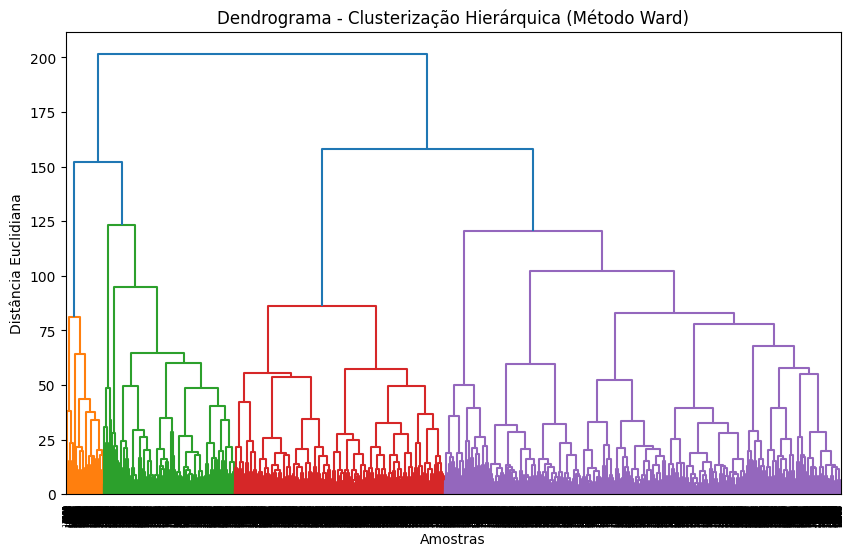

In [25]:
# 1. Exibir dendrograma com o DataFrame normalizado
get_clusters.plot_dendrogram(df_normalized, features)

In [26]:
# 2. Aplicar Agglomerative Clustering com o DataFrame normalizado
n_clusters = 4  # Número de clusters escolhido após análise do dendrograma
df_normalized = get_clusters.apply_agglomerative_clustering(df_normalized, features, n_clusters)

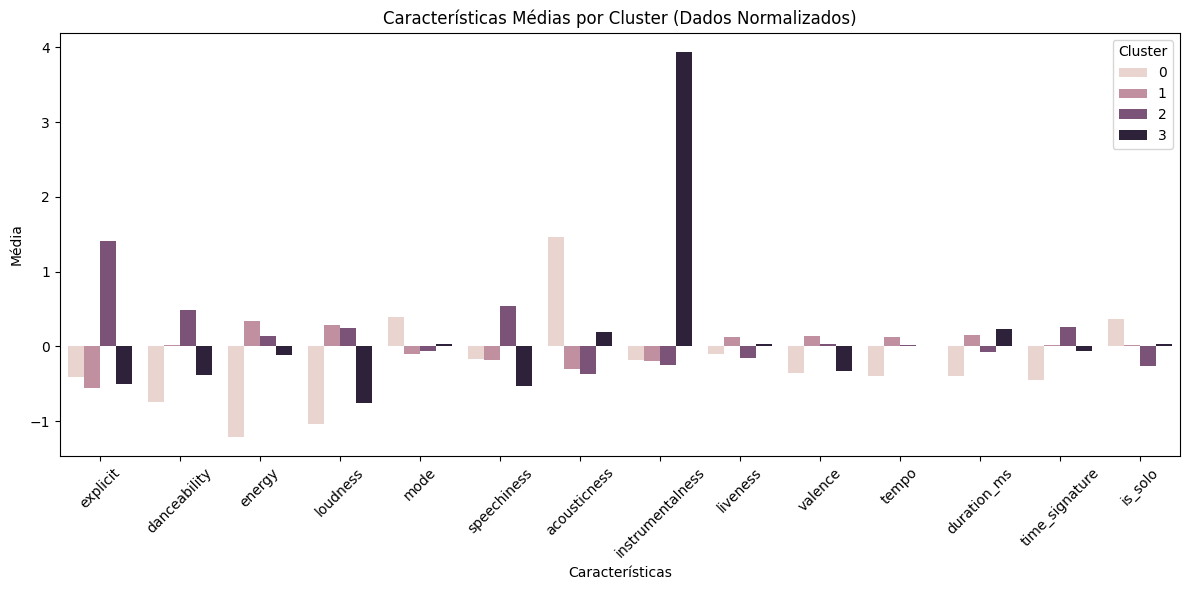

In [27]:
# 3. Plot das características médias por cluster (dados normalizados)
get_clusters.plot_cluster_characteristics(df_normalized, features, 'Cluster_Hierarchical')

In [28]:
# Atualizar a coluna 'Cluster_Hierarchical' no DataFrame original
Artist_tracks.loc[:, 'Cluster_Hierarchical'] = df_normalized['Cluster_Hierarchical']
Artist_tracks

C:\Users\35196\AppData\Local\Temp\ipykernel_28392\1145427484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Artist_tracks.loc[:, 'Cluster_Hierarchical'] = df_normalized['Cluster_Hierarchical']


,track_id,name,album,album_id,artist_name,artist_id,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,is_solo,Cluster_Hierarchical
0,78XK5PDIKWiDKcgiLl1x0o,Still Disappointed,Still Disappointed,4FCwf4rl9ZyRWzIy17ZZ6i,Stormzy,2SrSdSvpminqmStGELCSNd,1,0.731,0.6740,1,...,0.2740,0.09430,0.000000,0.0807,0.701,139.916,165027,4.0,1,2
1,6hkr5ZGVOt3Z2BNGE6yqpB,Lola,Lola,6gAbGdT5sKGgRsGbkdhk33,Iggy Azalea,5yG7ZAZafVaAlMTeBybKAL,1,0.774,0.5730,10,...,0.1400,0.01320,0.000000,0.1450,0.400,141.885,232123,4.0,0,2
2,1yj1ZztSGITJ5Nf4mfH92c,Spin You Around,Stand Alone - EP,2F66LRNUc5LQRC9qEVhfeu,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,0,0.517,0.8770,4,...,0.0297,0.00147,0.000000,0.2080,0.616,150.004,212850,4.0,1,1
3,77Q8V48a8jGsghvaVNWMaP,Sleep When We're Dead,Stand Alone - EP,2F66LRNUc5LQRC9qEVhfeu,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,0,0.564,0.8220,10,...,0.0329,0.01650,0.000003,0.3770,0.695,149.988,261642,4.0,1,1
4,5Gy4y79aKl44KZ2BpmgY7P,Stand Alone,Stand Alone - EP,2F66LRNUc5LQRC9qEVhfeu,Morgan Wallen,4oUHIQIBe0LHzYfvXNW4QM,0,0.458,0.5450,5,...,0.0285,0.31200,0.000003,0.1190,0.177,147.939,249755,4.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14246,7kjEqI6eZ7YlFrGhxixnlN,ANTES QUE SE ACABE,EL ÚLTIMO TOUR DEL MUNDO,2d9BCZeAAhiZWPpbX9aPCW,Bad Bunny,4q3ewBCX7sLwd24euuV69X,0,0.693,0.5490,2,...,0.0577,0.50500,0.000047,0.3240,0.473,139.988,221187,4.0,1,0
14247,55QIntmvDd7pYpNKl5AK4s,In The Morning,In The Morning,4Z31ZtSbHbEMQAi5ZArKiv,Jennifer Lopez,2DlGxzQSjYe5N6G9nkYghR,0,0.684,0.7800,6,...,0.0772,0.10600,0.000000,0.2080,0.735,98.952,167290,4.0,1,1
14248,5sMt9VtgtuakJOUSvVMzhG,Hitman,Hitman,241KpFxFLg6NjeVLieKuah,Kelly Rowland,3AuMNF8rQAKOzjYppFNAoB,0,0.648,0.8770,10,...,0.0438,0.00456,0.000008,0.2190,0.829,98.025,194306,4.0,0,1
14249,3qgK1i52jyuvz8ATQmMLTx,Blue Skies,Blue Skies,1m50nO6LDcbAsv82M2KaZR,Birdy,2WX2uTcsvV5OnS0inACecP,0,0.413,0.0822,6,...,0.0562,0.98100,0.000026,0.1060,0.173,77.299,154869,4.0,1,0


In [29]:
Artist_tracks.to_csv(processed_data / 'artist_tracks.csv', index=False)

## Parquet Files

In [30]:
ficheiros = [processed_data / 'artist_details.csv', processed_data / 'artist_tracks.csv']
parquet_converter.parquet(ficheiros)

Ficheiro convertido para Parquet e salvo como: C:\Users\35196\Desktop\Bases de dados distribuídas avançadas\BDDA\data\processed\artist_details.parquet
Ficheiro convertido para Parquet e salvo como: C:\Users\35196\Desktop\Bases de dados distribuídas avançadas\BDDA\data\processed\artist_tracks.parquet
